# Genetic diversity, with trees

Before we measured genetic diversity
using expected heterozygosity,
which is the proportion of sites that differ between two randomly chosen genomes:
for a genome of length $L$, with allele frequency $p_i$ at the $i^\text{th}$ site, this is:

$$
  \pi = \frac{1}{L}\sum_{i=1}^L 2 p_i (1-p_i) .
$$

We'll now derive this in a different way.
First, let's think about where the differences between trees come from.
As we saw before, they come from mutation, somewhere -
concretely, they come from mutations that happened
somewhere on the path from the two genomes
back up to their common ancestor.
(If there weren't any mutations, then they'd be identical;
if there's only one mutation, then they differ,
and if there was more than one mutation then it depends,
but this is rare and we mostly ignore it.)

Let's have a look at this in a small example.

In [1]:
%load_ext slim_magic

import tskit, pyslim
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, SVG

In [2]:
%%slim_ts --out ts
initialize()
{
    setSeed(123);
    initializeTreeSeq();
    initializeMutationRate(7e-8);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", c(m1), c(1.0));
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

1 {
    sim.addSubpop("p1", 500);
}

3000 late() {
    sim.treeSeqOutput("tmp.trees");
    sim.simulationFinished();
}

What we get here is a *tree sequence*:
see [this tutorial](https://tskit.dev/tutorials/intro.html) for an introduction,
and [the documentation](https://tskit.dev/tskit/docs/stable/introduction.html)
for what you can do with them.

In [3]:
ts

Let's suppose we take a sample of just 3 diploids from this population,
so we can easily look at their genealogies and genotypes.
We can do this with the `simplify( )` method:

In [4]:
sts = ts.simplify(range(6))
sts = pyslim.generate_nucleotides(sts)
sts = pyslim.convert_alleles(sts)
sts

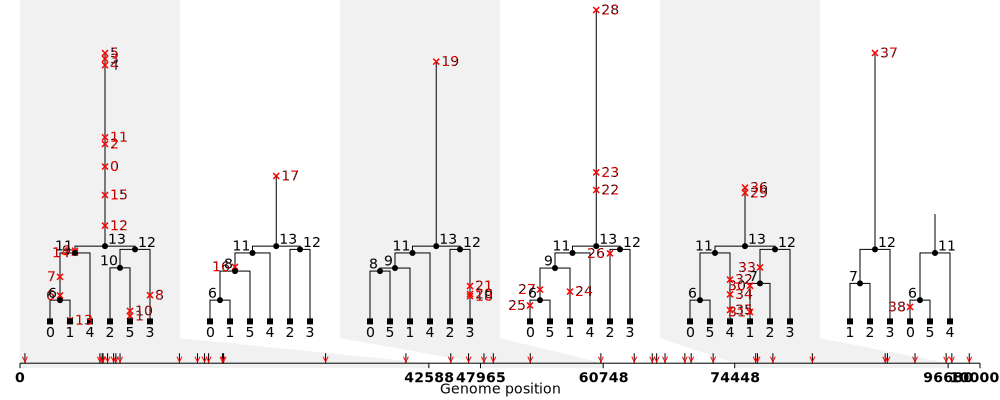

In [5]:
SVG(sts.draw_svg(size=(1000, 400)))

There are 38 sites (out of 100kb) at which we have mutations.
Some of these (shown on the roots of the trees above) are fixed in this sample,
i.e., don't differ between these six genomes.

Now, let's look at the six genotypes at these 38 sites:

In [6]:
for i, h in enumerate(sts.haplotypes()):
    print(f"sample {i}: ", h)

sample 0:  GCCGTGAAACGCGTCCTAAAACTGGACCGAGGCAGGGAG
sample 1:  GCCGTGAAACGCGACCTAAAACTGTGCAGATACGGGGCA
sample 2:  GCCGTGTTATGCGTTCCAAAACTGGGGAGAGGCGGGGCA
sample 3:  GCCGTGTTCTGCGTTCCATAGGTGGGCAGAGGCAGGGCA
sample 4:  GCCGTGTTACGCGTCCCAAAACTGGGCAGAGGAACCGAA
sample 5:  GGCGTGTTATCCGTTCTAAAACTGGGCCGAGGCAGGGAA


In [7]:
print(f"Expected heterozygosity in the subsample is {sts.diversity():.2g}, "
      f"while in the entire population it was {ts.diversity():.2g}.")

Expected heterozygosity in the subsample is 9.9e-05, while in the entire population it was 0.00012.


**Exercise:**
Compute heterozygosity in this subsample by hand
by looking at the genotypes above.
(*Hint:* sum up $2p_i(1-p_i)$ and divide by the genome length.)

## Drift-mutation balance, again

Let's derive the expression we got for equilibrium genetic diversity
again, but this time looking at the trees.
We want to know *what's the probability that two genomes differ at a given site?*
Well, suppose the two genomes live at the same time (call it "today"),
and their most recent common ancestor lived $T$ generations ago.
So, there were $2T$ reproduction events during which a mutation would have been inherited by
one and not the other of the genomes.
Let's use a different simplified mutation model this time:
the *infinite sites* model,
assuming that we can count up *all* mutations that differ between the two genomes.
(This differs from the previous model, where two mutations could cancel each other out.)
Afterwards, we can see how much of an effect the unrealistic parts
of this model might have.

The number of mutations, $M$, has a Binomial distribution
with sample size $2T$ and probability $\mu$,
so the expected number of mutations per site
(i.e., the heterozygosity) is

$$\begin{aligned}
   \pi = \mathbb{E}\left[ 2 T \mu \right] .
\end{aligned}$$

So, what is $\mathbb{E}[T]$?
Well, under the Wright-Fisher model,
the probability that two genomes find their common ancestor each generation is $1/2N$,
and so

$$
   \mathbb{P}\left\{ T > t \right\} = (1 - 1/2N)^t .
$$

This is the Geometric distribution,
and has mean $\mathbb{E}[T] = 2N$.
This implies that, precisely under this model of mutation,

$$
   \pi = 4 N \mu .
$$

This agrees with our previous calculation!
The advantage to this one is that it brings the trees into focus:
we see that heterozygosity
is equal, on average, to $4 \mu$ times the mean time to most recent common ancestor.
This fact is much more general than the Wright-Fisher model.

And, along the way, we've learned that the mean pairwise time to most recent common ancestor
in a Wright-Fisher population of size $N$ is $2N$ generations.
This is very useful!
